<a href="https://colab.research.google.com/github/marloncalvo/cap4630-spr2020/blob/master/hw2/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Function plotting with a twist!

## Generating Function Mesh / Critical Points

In [0]:
import math
import numpy as np

import plotly.graph_objects as go
from plotly.subplots import make_subplots

On the generated function data, I run a gradient on the Z output, where I run a simple heuristic to find the local min, max, and saddle points.

The idea is simple, local min's only happens when the sign goes from negative to positive. Similarly, maximums occur when the sign goes from positive to negative.

I greedily decided to bin points where the sign are opposite in both dimensions, so that when it's not a local max, or a min, it can be a saddle.

In [0]:
def get_function_coordinates(fun, a, b, resolution):
  x, y = np.meshgrid(np.linspace(a, b, resolution), np.linspace(a, b, resolution))
  z = fun(x, y)
  return x,y,z

# This assumes that local max, min, and saddle points will have distinct separate values
def sign(a):
  if a < 0:
    return -1
  else:
    return 1

def get_critical_points(xs, ys, zs):
  """
  This function will try to find all critical points, defined by
  sections where the gradients surrounding a cell are opposite sign
  to current.
  """
  sec_grad_x = np.diff(zs,n=1,axis=0)
  sec_grad_y = np.diff(zs,n=1,axis=1)

  n = len(sec_grad_x)

  local_min = {
      'x': [],
      'y': [],
      'z': [],
  }

  local_max = {
      'x': [],
      'y': [],
      'z': [],
  }

  saddle = {
      'x': [],
      'y': [],
      'z': [],
  }

  # Loop through every x,y combination.
  for i in range(1,n-1):
      for j in range(1,n-1):
          # find where the surrounding cells have opposite signs
          x_sign_prev = sign(sec_grad_x[i-1,j])
          x_sign      = sign(sec_grad_x[i,j])
          y_sign      = sign(sec_grad_y[i-1,j])
          y_sign_prev = sign(sec_grad_y[i,j-1])

          # Going from negative to positive.
          # Assuming that if both sign go from neg -> pos, its a local min.
          if x_sign_prev < x_sign and y_sign_prev < y_sign:
              local_min['y'].append(xs[j,i])
              local_min['x'].append(ys[j,i])
              local_min['z'].append(zs[i,j])

          # Going from positive to negative.
          # Same assumption, but local max.
          elif x_sign_prev > x_sign and y_sign_prev > y_sign:
              local_max['y'].append(xs[j,i])
              local_max['x'].append(ys[j,i])
              local_max['z'].append(zs[i,j])

          # If the signs are different, but x,y prev signs are not the same,
          # we'll assume it's a saddle.
          elif x_sign_prev != x_sign and y_sign_prev != y_sign:
              saddle['y'].append(xs[j,i])
              saddle['x'].append(ys[j,i])
              saddle['z'].append(zs[i,j])

  local_min['x'] = np.array(local_min['x'])
  local_min['y'] = np.array(local_min['y'])
  local_min['z'] = np.array(local_min['z'])

  local_max['x'] = np.array(local_max['x'])
  local_max['y'] = np.array(local_max['y'])
  local_max['z'] = np.array(local_max['z'])

  saddle['x'] = np.array(saddle['x'])
  saddle['y'] = np.array(saddle['y'])
  saddle['z'] = np.array(saddle['z'])

  return {
      'local_min': local_min,
      'local_max': local_max,
      'saddle': saddle
  }

## Functions for Generating 2D plots, Scatter Plots, and Density Plots

In [0]:
def plot_2d_scatter(fig, x, y, z, color, name, row, col):
  fig.add_trace(go.Scatter3d(
      x=x,y=y,z=z,
      mode='markers',
      marker_color=color,
      name=name),
      row, col
  )
  
def plot_scatter(fig, x, y, color, name, row, col):
  fig.add_trace(go.Scatter(
      x=x,y=y,
      mode='markers',
      marker_color=color,
      name=name),
      row, col
  )

def plot_surface_and_scatter(fig, plot, local_min, local_max, saddle, row, col):
    fig.add_trace(go.Surface(
      x=plot['x'],y=plot['y'],z=plot['z'],opacity=0.85,showscale=False), row, col
    )

    plot_2d_scatter(fig, local_min['x'], local_min['y'], local_min['z'], 'rgba(0, 0, 255, .9)', 'Minimum', row, col)
    plot_2d_scatter(fig, local_max['x'], local_max['y'], local_max['z'], 'rgba(255, 0, 0, .9)', 'Maximum', row, col)
    plot_2d_scatter(fig, saddle['x'], saddle['y'], saddle['z'], 'rgba(0, 255, 0, .9)', 'Saddle', row, col)

def plot_heatmap(fig, axis_vector, z, local_min, local_max, saddle, row, col):
  fig.add_trace(go.Heatmap(
    x=axis_vector, y=axis_vector, z=z, zsmooth='best',showscale=False),
    row,col
  )

  plot_scatter(fig, local_min['x'], local_min['y'], 'rgba(0, 0, 255, .9)', 'Minimum', row, col)
  plot_scatter(fig, local_max['x'], local_max['y'], 'rgba(255, 0, 0, .9)', 'Maximum', row, col)
  plot_scatter(fig, saddle['x'], saddle['y'], 'rgba(0, 255, 0, .9)', 'Saddle', row, col)

def plot_contour(fig, axis_vector, z, local_min, local_max, saddle, row, col):
  fig.add_trace(go.Contour(
    x=axis_vector, y=axis_vector, z=z),
    row,col
  )

  plot_scatter(fig, local_min['x'], local_min['y'], 'rgba(0, 0, 255, .9)', 'Minimum', row, col)
  plot_scatter(fig, local_max['x'], local_max['y'], 'rgba(255, 0, 0, .9)', 'Maximum', row, col)
  plot_scatter(fig, saddle['x'], saddle['y'], 'rgba(0, 255, 0, .9)', 'Saddle', row, col)

## Functions to find local min/max/saddle, and render all plots

In [0]:
def do_plot(plots, rows=3):
  n = len(plots)
  fig = make_subplots(rows=n, cols=3,
    specs=[[{'is_3d': True}, {'type': 'heatmap'}, {'type': 'contour'}] for i in range(n)],
  )

  for i, plot in enumerate(plots):

    plot = plot
    critical_points = plot['critical_points']

    local_min = critical_points['local_min']
    local_max = critical_points['local_max']
    saddle    = critical_points['saddle']

    plot_surface_and_scatter(fig, plot, local_min, local_max, saddle, i+1, 1)
    plot_heatmap(fig, plot['axis_vector'], plot['z'], local_min, local_max, saddle, i+1, 2)
    plot_contour(fig, plot['axis_vector'], plot['z'], local_min, local_max, saddle, i+1, 3)

  fig.show()

def plot_functions(fs, low=-10, high=10, resolution=25):
  plots = []
  for f in fs:
    x,y,z = get_function_coordinates(f, low, high, resolution)
    critical_points = get_critical_points(x,y,z)

    max_points    = []
    min_points    = []
    saddle_points = []

    plot = {'x': x, 
            'y': y, 
            'z': z,
            'axis_vector': np.linspace(low, high, resolution),
            'critical_points': critical_points}

    plots.append(plot)
  
  do_plot(plots)

## Three example plots

In the following graphs, you will see that along each plot, the following are defined.
* Saddle point, as a green dot.
* Absolute maximum, as a red dot.
* Absolute minimum, as a dark blue dot.

In [0]:
def f(x,y): return x**2 + y**2
def g(x,y): return np.cos(x) + np.sin(y)
def h(x,y): return x**2 - y**2

In [6]:
plot_functions([f], low=-5, high=5, resolution=100)

In [7]:
plot_functions([g], low=-5, high=5, resolution=50)

In [8]:
plot_functions([h], low=-5, high=5, resolution=50)

# Problem 2: Gradient Descent

I created a solution that works for any N number of dimensions. There are example functions provided to generate 1d, 2d, and 3d test cases. NOTE: Visualization is only supported for 2d.

## Training Data Generation

In [0]:
import numpy as np

The idea here is to create all the possible combinations, for each axis in input.

For each example, $E_i$, produce a new row with
$N+1$ columns, where $N$ is the dimensionality of $E$, where column 1 contains 1, and all other contain the input for the $A_i$ parameter.

In [0]:
def generate_examples(f, input):
  dimensions = len(input)
  mesh = np.meshgrid(*input)
  combs = np.array(mesh).T.reshape(-1, dimensions)

  test_mesh = np.meshgrid([5 * np.random.rand(100, 1) for i in range(dimensions)])
  test_combs = np.array(test_mesh).T.reshape(-1, dimensions)

  v = []
  v2 = []
  """
  Although I'm aware that I could use np's syntax to generate
  these arrays on the fly, this seems easier to work with when dealing
  with higher-order functions.
  """
  for comb in combs:
    v.append(f(*comb))

  for comb in test_combs:
    v2.append(f(*comb))

  return np.array(v).reshape(len(v), 1), combs, np.array(v2).reshape(len(v2), 1), test_combs

### Friendly functions to automate generation of training data.

In [0]:
@np.vectorize
def f(x,y,z):
  return 11 * z + 8 * y + 3 * x + 14

@np.vectorize
def g(x,y):
  return 15 * y + 3 * x + 19

@np.vectorize
def h(x):
  return 3 * x + 19

def examples_3d(m):
  inputs = [
      5 * np.random.rand(m, 1),
      5 * np.random.rand(m, 1),
      5 * np.random.rand(m, 1)
  ]

  train_y, train_combs, test_y, test_combs = generate_examples(g, inputs)
  train_x = np.concatenate((np.ones((len(train_y),1)), train_combs), axis=1)
  test_x = np.concatenate((np.ones((len(test_y),1)), test_combs), axis=1)
  ws = np.zeros((train_x.shape[1], 1))
  
  return train_y, train_x, test_x, test_y, ws

def examples_2d(m):
  inputs = [
      5 * np.random.rand(m, 1),
      5 * np.random.rand(m, 1),
  ]

  train_y, train_combs, test_y, test_combs = generate_examples(g, inputs)
  train_x = np.concatenate((np.ones((len(train_y),1)), train_combs), axis=1)
  test_x = np.concatenate((np.ones((len(test_y),1)), test_combs), axis=1)
  ws = np.zeros((train_x.shape[1], 1))

  return train_y, train_x, test_x, test_y, ws

def examples_1d(m):
  inputs = [
      5 * np.random.rand(m, 1),
  ]

  train_y, train_combs, test_y, test_combs = generate_examples(g, inputs)
  train_x = np.concatenate((np.ones((len(train_y),1)), train_combs), axis=1)
  test_x = np.concatenate((np.ones((len(test_y),1)), test_combs), axis=1)
  ws = np.zeros((train_x.shape[1], 1))
  
  return train_y, train_x, test_x, test_y, ws


## Training and Test Data Visualization

In [0]:
train_y, train_x, test_x, test_y, ws = examples_2d(25) # Remeber, this is N for each dimension. so N^( # of dimensions )

In [21]:
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, 
  specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]],
  subplot_titles=("Training Y's", "Test Y's"))

fig.add_trace(go.Scatter3d(x=train_x[:,1], y=train_x[:,2], z=train_y.flatten(),
                           showlegend=False, mode='markers'), row=1, col=1)
fig.add_trace(go.Scatter3d(x=test_x[:,1], y=test_x[:,2], z=test_y.flatten(),
                           showlegend=False, mode='markers'), row=1, col=2)
fig.update_layout(
    autosize=False,
    width=1200,
    height=500
)
fig.show()

## Training!

Same idea as the provided solution.

Each row in $ys$ contains one example, and each row in $ws$ contains the weight for the $i'th$ parameter.

Performing matrix multiplication, we get $\hat{y}$ for each example.

Then we simply calculate the gradient from there, and update $ws$.

In [0]:
def train(ws, xs, ys, epochs=100, lr=0.5):
  n = ys.shape[0]

  for epoch in range(epochs):
    gradient = 1/n * np.matmul(xs.T, np.matmul(xs, ws) - ys)
    ws = ws - lr * gradient

  return ws

In [16]:
weights = train(ws, train_x, train_y, epochs=1000, lr=0.10)
print(weights)

[[18.99986778]
 [ 3.00002391]
 [15.00002087]]


In [0]:
def plot_train(weights, train_x, train_y, test_x, test_y, epochs=100, lr=0.5, col=0):
  n = train_y.shape[0]

  y_predict = np.matmul(test_x, weights)
  fig.add_trace(go.Scatter3d(x=train_x[:,1], y=train_x[:,2], z=train_y.flatten(), 
                             mode='markers', name='Training Values', 
                             legendgroup='1',
                             marker_color='rgba(0, 116, 217, 1)',
                             showlegend=col==1), row=1, col=col)
  fig.add_trace(go.Scatter3d(x=test_x[:,1], y=test_x[:,2], z=y_predict.flatten(), 
                             mode='markers', name='Initial Predictions', 
                             legendgroup='2',
                             marker_color='rgba(1, 255, 112, 1)',
                             showlegend=col==1), row=1, col=col)

  for epoch in range(epochs):
    gradient = 1/n * np.matmul(train_x.T, np.matmul(train_x, weights) - train_y)
    weights = weights - lr * gradient

  y_predict = np.matmul(test_x, weights)
  fig.add_trace(go.Scatter3d(x=test_x[:,1], y=test_x[:,2], z=y_predict.flatten(), 
                             mode='markers', name='Final Predictions', 
                             legendgroup='3',
                             marker_color='rgba(255, 133, 27, 1)',
                             showlegend=col==1), row=1, col=col)

  return weights

In [18]:
fig = make_subplots(rows=1, cols=4, 
                    specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}, {"type": "scatter3d"}]],
                    subplot_titles=("LR 0.01", "LR 0.025", "LR 0.05", "LR 0.10"))
plot_train(ws, train_x, train_y, test_x, test_y, epochs=10, lr=0.01, col=1)
plot_train(ws, train_x, train_y, test_x, test_y, epochs=10, lr=0.025, col=2)
plot_train(ws, train_x, train_y, test_x, test_y, epochs=10, lr=0.05, col=3)
plot_train(ws, train_x, train_y, test_x, test_y, epochs=10, lr=0.10, col=4)
fig.update_layout(
  title={
    'text': "Plot For Varying Learning Rates",
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
)
fig.show()

# Problem 3

In [19]:
%tensorflow_version 2.x
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

TensorFlow 2.x selected.
11493376/11490434 [==============================] - 0s 0us/step


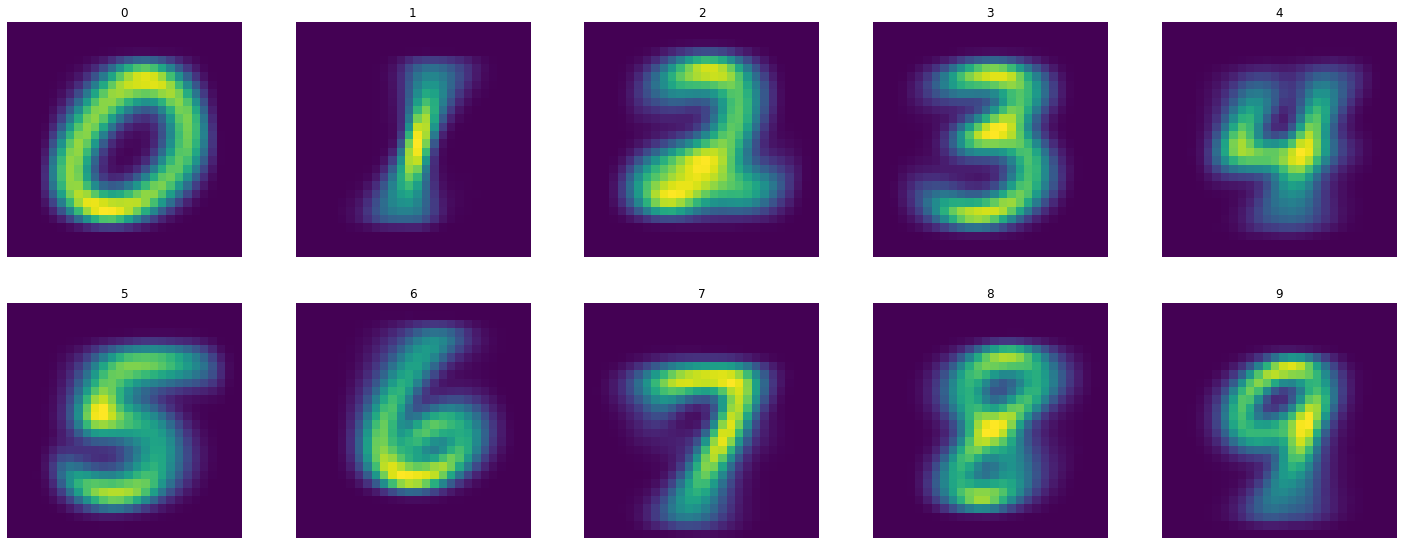

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

all_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

digits = {}
for digit in all_digits:
  digits[digit] = (np.zeros((28, 28)), 0)

# This assumes 'all_digits' is a subset of 'train_labels'
for i, digit_image in enumerate(train_images):
  (image, n) = digits[train_labels[i]]
  digits[train_labels[i]] = (image + digit_image, n + 1)

plt.figure(figsize=(25, 25))
for digit in digits:
  (image, n) = digits[digit]
  image = image / n

  ax = plt.subplot(5, 5, digit+1)
  plt.imshow(image)
  plt.title(digit)
  plt.axis('off')